In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Flickr8k/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data'

In [ ]:
# LAB 색 체계  : 명도를 나타내는 L채널과 색을 나타내는 A,B 채널
# Let there the color 모델은
# 로 레벨 특징추출기 : 이미지의 국소적인 특징
# 글로벌 레벨 특징추출기 : 전체적인 특징
# 미들 레벨 특징추출기 : 중간크기의 특징
# 컬러라이제이션 신경망 : 특징으로부터 색을 학습
# repeat() 함수 : 텐서를 지정한 차원의 방향으로 복제

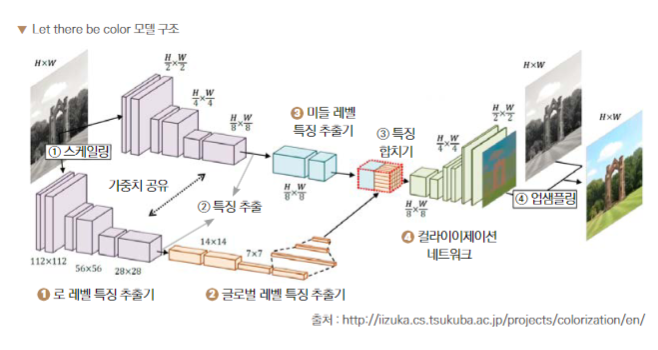

In [3]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
imgs = glob.glob('/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/*.jpg')
imgs[:5]

['/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/1003163366_44323f5815.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/1007129816_e794419615.jpg']

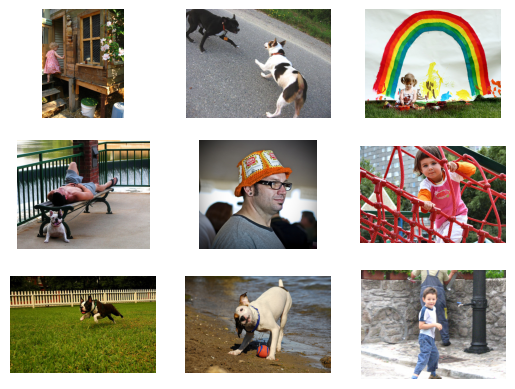

In [5]:
for i in range(9):
  img = Image.open(imgs[i])
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()  

In [6]:
# RGB --> LAB 전처리과정
# opencv cvtColor()함수
# LAB : 이미지의 밝기와 A,B 두 가지 색을 이용해 서 색을 표현
# L채널이 흑백이미지, A채널은 녹색과 적색, B채널은 청색과 노란색
# 

In [8]:
# RGB -> LAB 로 변환하는 함수
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset
def rgb2lab(rgb):
  return cv2.cvtColor(rgb,cv2.COLOR_RGB2LAB)

In [14]:
img = Image.open(imgs[i])
np.array(img).shape , rgb2lab(np.array(img)).shape

((375, 500, 3), (375, 500, 3))

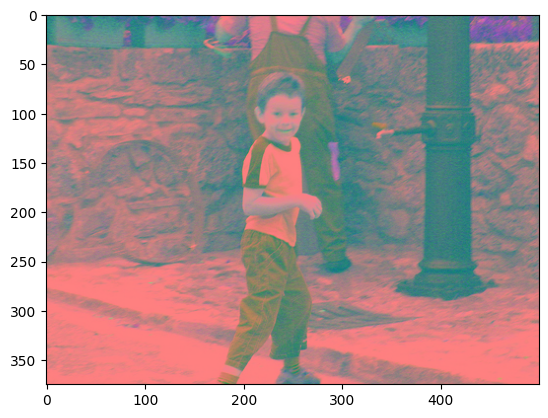

In [15]:
plt.imshow(rgb2lab(np.array(img)))

In [16]:
# 학습용 데이터셋
class AutoColoring(Dataset):
  def __init__(self) -> None:
    self.data = glob.glob('/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/*.jpg')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    # RGB 이미지 불러오기
    rgb = np.array(Image.open(self.data[index]).resize( (256,256) ) )
    # LAB로 변환
    lab = rgb2lab(rgb)
    # 채널 차원이 가장 앞에 오도록 변경
    lab = lab.transpose( (2,0,1) ).astype(np.float32)
    return lab[0], lab[1:]  # 모델의 입력으로 흑백이미지가 들어가고 L채널이 입력데이터, 색은 AB채널

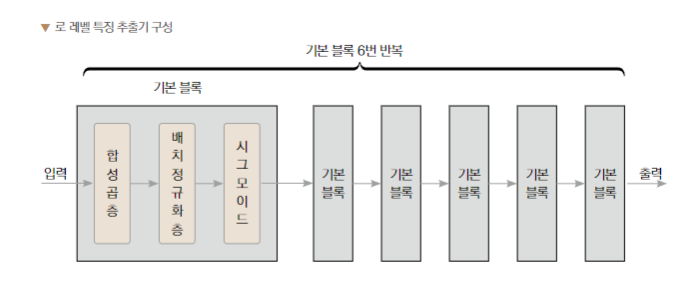

In [17]:
# 로 레벨 측정기
import torch
import torch.nn as nn

In [ ]:
class LowLevel(nn.Module):
  def __init__(self):
    super(LowLevel,self).__init__()
    self.low1 = nn.Conv2d(1,64,kernel_size=3,stride=2,padding=1)
    self.lb1 = nn.BatchNorm2d(64)
    self.low2 = nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.lb2 = nn.BatchNorm2d(128)
    self.low3 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.lb3 = nn.BatchNorm2d(128)

    self.low4 = nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.lb4 = nn.BatchNorm2d(256)
    self.low5 = nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1)
    self.lb5 = nn.BatchNorm2d(512)
    self.low6 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.lb6 = nn.BatchNorm2d(512)

    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    low = self.low1(x)
    low = self.lb1(low)
    low = self.sigmoid(low)

    low = self.low2(low)
    low = self.lb2(low)
    low = self.sigmoid(low)

    low = self.low3(low)
    low = self.lb3(low)
    low = self.sigmoid(low)

    low = self.low4(low)
    low = self.lb4(low)
    low = self.sigmoid(low)

    low = self.low5(low)
    low = self.lb5(low)
    low = self.sigmoid(low)

    low = self.low6(low)
    low = self.lb6(low)
    low = self.sigmoid(low)   # 딥러닝에서 특징의 범위를 0과 1사이로 하는게 가장좋다, 로레벨은 미들/글로벌 특징 추출기에서사용
    # 이미지 크기를 점차 줄여 나가야 되기때문에 스트라이드와 패딩을 조정
    return low

In [18]:
class MidLevel(nn.Module):
  def __init__(self):
    super(MidLevel,self).__init__()
    self.mid1 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.mb1 = nn.BatchNorm2d(512)

    self.mid2 = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.mb2 = nn.BatchNorm2d(256)

    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    mid = self.mid1(x)
    mid = self.mb1(mid)
    mid = self.sigmoid(mid)

    mid = self.mid2(x)
    mid = self.mb2(mid)
    mid = self.sigmoid(mid)    
    return mid

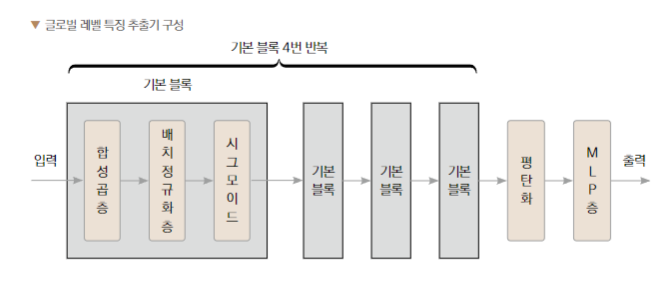